In [1]:
import os
import json
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# local files
import metrics as mt
import compute_KL as ckl
import scipy.stats as stats
from scipy.stats import pearsonr

import random

%load_ext autoreload

%autoreload 2

In [2]:
hospital_file = '/home/ubuntu/projects/more-data-more-problems/YAIB-cohorts/data/mortality24/eicu/above2000.txt'
df = pd.read_csv(hospital_file, header=None)

In [5]:
n = 12
hospital_ids = df[0].values[:n]

hospital_dict = {} 
for i in range(len(hospital_ids)):
    hospital_dict[hospital_ids[i]] = i

def plot_scatter_with_correlation(data, key1, key2, figsize=(6, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(data=data, x=key1, y=key2, ax=ax)
    
    corr_coef, p_value = pearsonr(data[key1], data[key2])
    text_str = f'Correlation Coefficient: {corr_coef:.2f}\np-value: {p_value:.2e}'
    ax.text(0.55, 0.95, text_str, transform=ax.transAxes, fontsize=12, verticalalignment='top')
    
    ax.set_xlabel(key1)
    ax.set_ylabel(key2)
    plt.tight_layout()
    plt.show()
    
def partition_array(arr):
    # Shuffle the array using the Fisher-Yates shuffle algorithm
    for i in range(len(arr) - 1, 0, -1):
        j = random.randint(0, i)
        arr[i], arr[j] = arr[j], arr[i]

    # Partition the array into two halves
    mid = len(arr) // 2
    first_half = arr[:mid]
    second_half = arr[mid:]

    return first_half, second_half

## Section 0: PCA explained variance: 
It would take almost 40 components to exmplain 95% of the variance

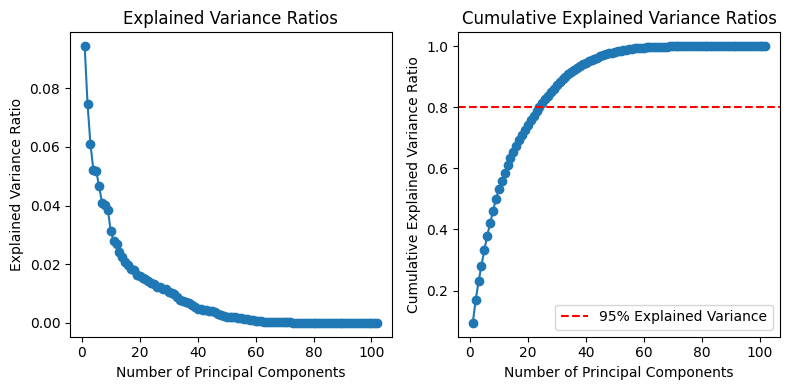

In [11]:
from sklearn.decomposition import PCA
x_train, y_train, xy_train = ckl.get_hospital(73, 'train')

pca = PCA()
X_pca = pca.fit_transform(xy_train)


# Calculate the explained variance ratios
explained_variance_ratios = pca.explained_variance_ratio_

# Calculate the cumulative explained variance ratios
cumulative_explained_variance_ratios = np.cumsum(explained_variance_ratios)
fig, (ax1, ax2) = plt.subplots(1,  2, figsize=(8, 8))

# Plot the explained variance ratios
ax1.plot(range(1, len(explained_variance_ratios) + 1), explained_variance_ratios, marker='o')
ax1.set_xlabel('Number of Principal Components')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Explained Variance Ratios')

# Plot the cumulative explained variance ratios
ax2.plot(range(1, len(cumulative_explained_variance_ratios) + 1), cumulative_explained_variance_ratios, marker='o')
ax2.set_xlabel('Number of Principal Components')
ax2.set_ylabel('Cumulative Explained Variance Ratio')
ax2.set_title('Cumulative Explained Variance Ratios')
ax2.axhline(y=0.80, color='r', linestyle='--', label='95% Explained Variance')
ax2.legend()

plt.tight_layout()
plt.show()

## Section 1: Evaluate Quality of KL Estimation

### Section 1a: Density Estimation Based KL

In [15]:
size_arr = [5, 10, 15] #, 20]
for size in size_arr: 
    results = np.load(f'YAIB/results/distances/KL-n2000-c{size}-pair.npz', allow_pickle=True)
    KL_xy = results['KL_xy']
    base_corr = [] 
    for i in range(len(KL_xy)): 
        for j in range(i+1, len(KL_xy)): 
            base_corr.append(pearsonr(KL_xy[i].flatten(), KL_xy[j].flatten())[0])

/tmp/ipykernel_629547/3192379274.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  base_corr.append(pearsonr(KL_xy[i].flatten(), KL_xy[j].flatten())[0])


In [16]:
corr_dim = np.zeros((len(size_arr), len(size_arr)))
for i in range(len(size_arr)): 
    results = np.load(f'YAIB/results/distances/KL-n2000-c{size_arr[i]}-pair.npz', allow_pickle=True)
    KL_xy1 = results['KL_xy'].mean(axis=0) 
    for j in range(i+1, len(size_arr)): 
        results = np.load(f'YAIB/results/distances/KL-n2000-c{size_arr[j]}-pair.npz', allow_pickle=True)
        KL_xy2 = results['KL_xy'].mean(axis=0)
        corr_dim[i, j] = pearsonr(KL_xy1.flatten(), KL_xy2.flatten())[0]
        corr_dim[j, i] = corr_dim[i, j]
corr_dim

array([[0.        , 0.72949795, 0.08027301],
       [0.72949795, 0.        , 0.06119963],
       [0.08027301, 0.06119963, 0.        ]])

### Section 1b: Ratio Based KL

In [ ]:
# Distribution Shift KL
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

results_x = np.zeros((len(hospital_ids), len(hospital_ids))) 
results_xy = np.zeros((len(hospital_ids), len(hospital_ids))) 
for test_i, test_h in enumerate(hospital_ids): 
    for i, h in enumerate(hospital_ids): 
        hos = test_h
        if h != hos: 
            x, y, xy = ckl.get_hospital(h, 'train')
            x2, y2, xy2 = ckl.get_hospital(hos, 'train')
            
            scaler = StandardScaler()
            logistic = LogisticRegression(max_iter=10000, tol=0.1)
            pipe = Pipeline(steps=[("scaler", scaler), ("logistic", logistic)])

            # fit x 
            X_train = np.concatenate((x, x2), axis=0)
            Y_train = np.concatenate((np.ones(len(x)), np.zeros(len(x2))), axis=0)
            
            pipe.fit(X_train, Y_train)
            
            x_val, _, _ = ckl.get_hospital(h, 'test')
            results_x[i, test_i] = (pipe.predict_log_proba(x_val)[:, 1].mean())

            # fit xy 
            X_train = np.concatenate((xy, xy2), axis=0)
            Y_train = np.concatenate((np.ones(len(xy)), np.zeros(len(xy2))), axis=0)
            
            pipe.fit(X_train, Y_train)
            _, _, xy_val = ckl.get_hospital(h, 'test')
            results_xy[i, test_i] = (pipe.predict_log_proba(xy_val)[:, 1].mean())

with open('YAIB/results/distances/KL-ratio-xy.npy', 'wb') as f: 
    np.save(f, results_xy) 

with open('YAIB/results/distances/KL-ratio-x.npy', 'wb') as f: 
    np.save(f, results_x) 

In [ ]:
# joint data KL

## Section 3: All hospital Correlation

In [97]:
size=10
results = np.load(f'YAIB/results/distances/KL-n2000-c{size}.npz', allow_pickle=True)
#avg = results['KL_xy'][0]
avg = np.mean(results['KL_xy'], axis=0)
sem = stats.sem(results['KL_xy'], axis=0)

In [98]:
LRdiff = np.load('YAIB/results/add_data/LogisticRegression-avg.npz')
LGBMdiff = np.load('YAIB/results/add_data/LGBMClassifier-avg.npz')
LSTMdiff = np.load('YAIB/results/add_data/LSTM-avg.npz')

In [99]:
# add data
LR_orig = np.load('YAIB/results/dist_shift/LogisticRegression-avg.npz')
LR_AUC = LRdiff[metric] + np.diagonal(LR_orig[metric])*np.eye(len(hospital_ids)) 
LR_ADD_AUC = LR_AUC - np.repeat(np.diagonal(LR_orig[metric]).reshape(-1, 1), len(hospital_ids), axis=1).T

In [100]:
# add data
n = 10
metric = 'AUC'
LR_AUC = np.load('YAIB/results/dist_shift/LogisticRegression-AUC-n1500-diff-avg.npz')[metric]
LGBM_AUC = np.load('YAIB/results/dist_shift/LGBMClassifier-AUC-diff-avg.npz')[metric]
LSTM_AUC = np.load('YAIB/results/dist_shift/LSTM-AUC-diff-avg.npz')[metric]

In [101]:
with open('YAIB/results/distances/KL-ratio-x.npy', 'rb') as f: 
    ratio_x = np.load(f)
with open('YAIB/results/distances/KL-ratio-xy.npy', 'rb') as f: 
    ratio_xy = np.load(f)

with open('YAIB/results/distances/KL-ratio-addition-x.npy', 'rb') as f: 
    add_ratio_x = np.load(f)
with open('YAIB/results/distances/KL-ratio-addition-xy.npy', 'rb') as f: 
    add_ratio_xy = np.load(f)

In [102]:
plot_df = pd.DataFrame()
plot_df['LR'] = LR_AUC[:n, :n].flatten()
plot_df['LGBM'] = LGBM_AUC[:n, :n].flatten()
plot_df['LSTM'] = LSTM_AUC[:n, :n].flatten()
plot_df['LR-ADD'] = LR_ADD_AUC[:n, :n].flatten()
plot_df['train_hospital'] = np.repeat(hospital_ids[:n], repeats=n)
plot_df['train_hospital'] = plot_df['train_hospital'].astype(str)
plot_df['test_hospital'] = np.repeat(hospital_ids[:n].reshape(-1, 1), repeats=n, axis=1).T.flatten()
plot_df['test_hospital'] = plot_df['test_hospital'].astype(str)
plot_df['KL_xy'] = avg[:n, :n].flatten()
plot_df['KL_ratio_x'] = ratio_x[:n, :n].flatten() 
plot_df['KL_ratio_xy'] = ratio_xy[:n, :n].flatten() 
plot_df['KL_add_ratio_x'] = add_ratio_x[:n, :n].flatten() 
plot_df['KL_add_ratio_xy'] = add_ratio_xy[:n, :n].flatten() 

plot_df['KL_x'] = np.mean(results['KL_x'], axis=0)[:n, :n].flatten()

In [103]:
import pickle

with open("YAIB/results/distances/distance_metrics.pk", 'rb') as file:
    # Load the data from the pickle file
    data = pickle.load(file)
    
hospital_dict = {} 
for i in range(len(hospital_ids)):
    hospital_dict[hospital_ids[i]] = i

for key in data.keys(): 
    dist = data[key]
    dist_pairwise = np.zeros((10, 10))
    for i, j in dist.keys(): 
        dist_pairwise[hospital_dict[i], hospital_dict[j]] = dist[(i, j)]

plot_df[key] = dist_pairwise.flatten()

plot_df = plot_df.drop(np.arange(0, n)*(n+1))

IndexError: index 10 is out of bounds for axis 1 with size 10

## KL

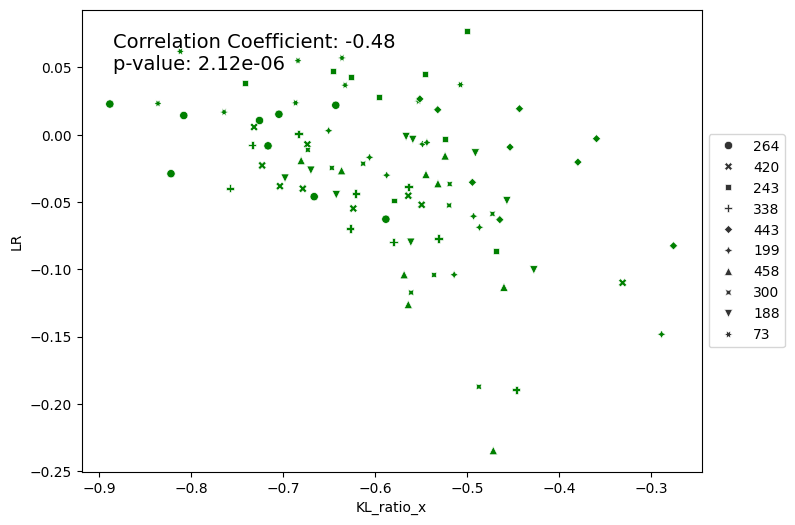

In [90]:
clf = 'LR'
dist = 'KL_ratio_x'

selected_df = plot_df #[plot_df['LR'] <= 0]
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=selected_df, y=clf, x=dist, style='test_hospital', c='g')
#sns.scatterplot(data=selected_df, x='LSTM', y=dist, style='train_hospital', c='g')
#sns.scatterplot(data=selected_df, x='LGBM', y=dist, style='train_hospital', c='b')
corr_coef, p_value = pearsonr(selected_df[clf], selected_df[dist])

# Add correlation coefficient and p-value to the plot
text_str = f'Correlation Coefficient: {corr_coef:.2f}\np-value: {p_value:.2e}'
ax.text(0.05, 0.95, text_str, transform=ax.transAxes,
        fontsize=14, verticalalignment='top')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

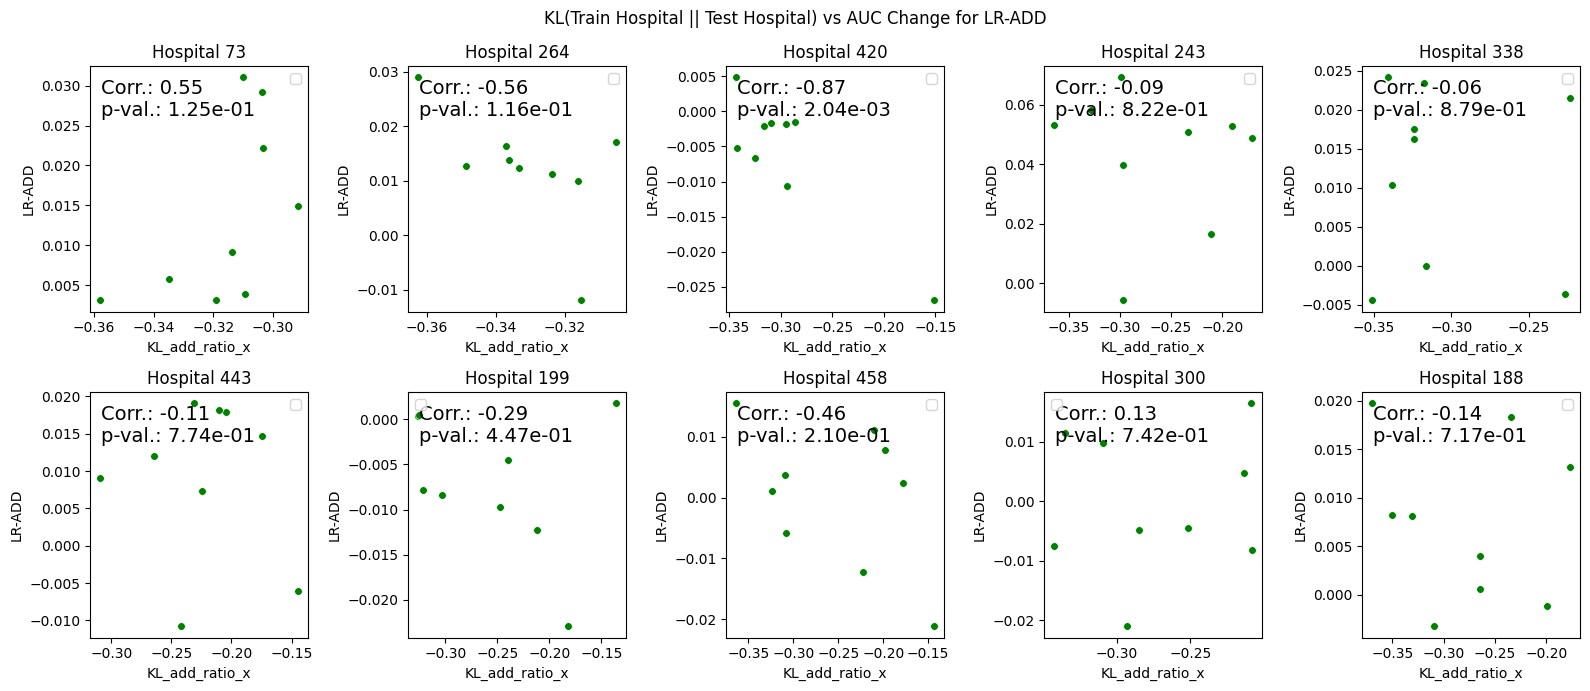

In [371]:
fig, axes = plt.subplots(figsize=(16,7), nrows=2, ncols=5)
clf = 'LR-ADD'
dist = 'KL_add_ratio_x'
for h, ax, in zip(hospital_ids, axes.flatten()): 
    test_hosp = str(h) 
    selected_df = plot_df[plot_df["test_hospital"] == test_hosp]

    sns.scatterplot(data=selected_df, x=dist, y=clf, c='g', ax=ax, s=30)
    #sns.scatterplot(data=selected_df, x='LSTM', y=dist, style='train_hospital', c='g')
    #sns.scatterplot(data=selected_df, x='LGBM', y=dist, style='train_hospital', c='b')
    corr_coef, p_value = pearsonr(selected_df[clf], selected_df[dist])
    
    # Add correlation coefficient and p-value to the plot
    text_str = f'Corr.: {corr_coef:.2f}\np-val.: {p_value:.2e}'
    ax.text(0.05, 0.95, text_str, transform=ax.transAxes,
            fontsize=14, verticalalignment='top')
    ax.legend([])
    ax.set_title(f"Hospital {h}")
plt.suptitle(f"KL(Train Hospital || Test Hospital) vs AUC Change for {clf}")
fig.tight_layout()

## Normative Distance

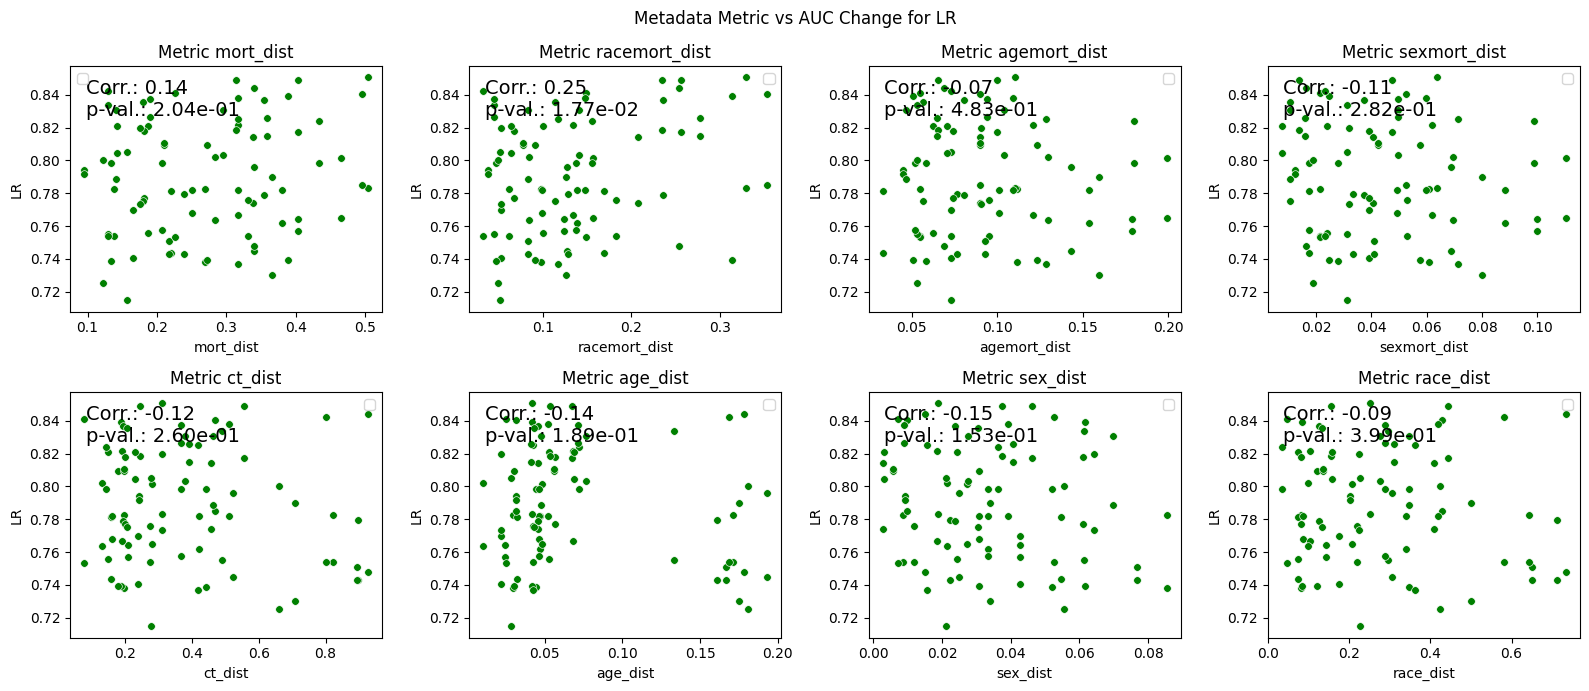

In [22]:
fig, axes = plt.subplots(figsize=(16,7), nrows=2, ncols=4)
clf = 'LR'
for met, ax, in zip(data.keys(), axes.flatten()): 
    selected_df = plot_df #[plot_df["test_hospital"] == '188']
    sns.scatterplot(data=selected_df, x=met, y=clf, c='g', ax=ax, s=30)
    #sns.scatterplot(data=selected_df, x='LSTM', y=dist, style='train_hospital', c='g')
    #sns.scatterplot(data=selected_df, x='LGBM', y=dist, style='train_hospital', c='b')
    corr_coef, p_value = pearsonr(selected_df[clf], selected_df[met])
    
    # Add correlation coefficient and p-value to the plot
    text_str = f'Corr.: {corr_coef:.2f}\np-val.: {p_value:.2e}'
    ax.text(0.05, 0.95, text_str, transform=ax.transAxes,
            fontsize=14, verticalalignment='top')
    ax.legend([])
    ax.set_title(f"Metric {met}")
plt.suptitle(f"Metadata Metric vs AUC Change for {clf}")
fig.tight_layout()

## Section 3: 1 Hospital Case Study: Hospital 199 

In [203]:
# addition_dict = {} 
# for i in range(len(hospital_ids)): 
#     hid = hospital_ids[i]
#     _, y, _ = ckl.get_hospital(hid, 'train')
#     len_train = len(y)
#     _, y, _ = ckl.get_hospital(hid, 'val')
#     len_val = len(y)
#     _, y, _ = ckl.get_hospital(hid, 'test')
#     len_test = len(y)
#     total_addition = int((len_train + len_val + len_test)*0.5)
#     addition_dict[hid] = total_addition

# with open('YAIB/results/add_data/num_addition.pk', 'wb') as handle:
#     pickle.dump(addition_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [163]:
hos=199
hos_ind = hospital_dict[hos]
model = "LogisticRegression"
avg_dict = np.load(f"YAIB/results/sequential-n/{hos}-{model}-avg.npz", allow_pickle=True)
ci_dict = np.load(f"YAIB/results/sequential-n/{hos}-{model}-ci.npz", allow_pickle=True)
dist_shift_avg = np.load(f"YAIB/results/dist_shift/{model}-avg.npz")
dist_shift_CI = np.load(f"YAIB/results/dist_shift/{model}-ci.npz")
data_addition_avg = np.load(f"YAIB/results/add_data/{model}-avg.npz")
data_addition_CI = np.load(f"YAIB/results/add_data/{model}-ci.npz")

with open('YAIB/results/add_data/num_addition.pk', 'rb') as handle:
    addition_dict = pickle.load(handle)

In [164]:
plot_df = pd.DataFrame.from_dict(avg_dict['AUC'].item(), orient='index', columns=['AUC'])
ci_lower_df =  pd.DataFrame.from_dict(ci_dict['AUC'][0], orient='index', columns=['CI-lower'])
ci_upper_df =  pd.DataFrame.from_dict(ci_dict['AUC'][1], orient='index', columns=['CI-upper'])
plot_df = pd.concat([plot_df, ci_lower_df, ci_upper_df], axis=1)

new_df = plot_df.reset_index(names='n')
new_df['train_hospital'] = hos

for i in range(len(hospital_ids)): 
    if hospital_ids[i] != hos: 
        new_hospital = {
            'n': addition_dict[hospital_ids[i]] + 2000, 
            'AUC': data_addition_avg['AUC'][:, hos_ind][i], 
            'CI-lower': data_addition_CI['AUC'][0][:, hos_ind][i],
            'CI-upper': data_addition_CI['AUC'][1][:, hos_ind][i], 
            'train_hospital': hospital_ids[i]
            }
        
        new_df.loc[len(new_df)] = new_hospital
        prev_result = new_df.loc[5].to_dict()
        prev_result['train_hospital'] = hospital_ids[i] 
        new_df.loc[len(new_df)] = prev_result



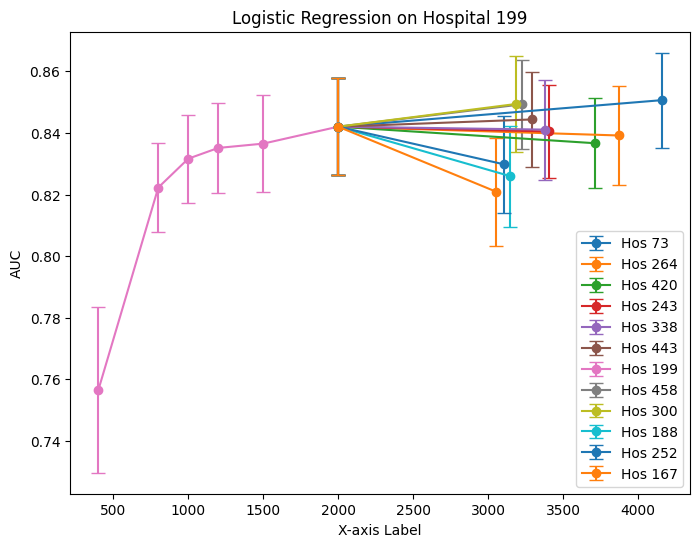

In [165]:
fig, ax = plt.subplots(figsize=(8, 6))
# Plot the mean AUC with confidence intervals as vertical bars
for i in range(len(hospital_ids)): 
    hos_df = new_df[new_df['train_hospital'] == hospital_ids[i]]
    ax.errorbar(x=hos_df['n'],
                y=hos_df['AUC'],
                yerr=[hos_df['AUC'] - hos_df['CI-lower'],hos_df['CI-upper'] -hos_df['AUC']],
                fmt='o-',
                capsize=5,
                label=f'Hos {hospital_ids[i]}')

# Set labels and title
ax.set_xlabel('X-axis Label')
ax.set_ylabel('AUC')
ax.set_title(f'Logistic Regression on Hospital {hos}')

# Show the legend
ax.legend()

# Display the plot
plt.show()

In [166]:
data_addition = new_df[new_df['n'] > 2000]
original_AUC = new_df[np.logical_and(new_df['n']==2000, new_df['train_hospital']==hos)]['AUC']
data_addition['AUC-diff'] = data_addition['AUC'] - original_AUC.values[0]

/tmp/ipykernel_629547/890666326.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_addition['AUC-diff'] = data_addition['AUC'] - original_AUC.values[0]


In [70]:
# density based KL
size=15
results = np.load(f'YAIB/results/distances/KL-n2000-c{size}-pair.npz', allow_pickle=True)
data_addition['KL_xy'] = np.delete(results['KL_xy'].mean(axis=0)[:, hos_ind], hos_ind)

/tmp/ipykernel_629547/1415548184.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_addition['KL_xy'] = np.delete(results['KL_xy'].mean(axis=0)[:, hos_ind], hos_ind)


In [112]:
data_addition['KL_ratio']

6     2.300698
8     1.384939
10    1.312766
12    1.084028
14    1.810598
16    1.879493
18    0.745298
20    1.051961
22    1.324051
24    2.053029
26    1.012827
Name: KL_ratio, dtype: float64

In [170]:
results = [] 
for i, h in enumerate(hospital_ids): 
    if h != hos: 
        x, y, xy = ckl.get_hospital(h, 'train')
        x2, y2, xy2 = ckl.get_hospital(hos, 'train')
        scaler = StandardScaler()
        logistic = LogisticRegression(max_iter=10000, tol=0.1)
        pipe = Pipeline(steps=[("scaler", scaler), ("logistic", logistic)])
        
        X_train = np.concatenate((xy, xy2), axis=0)
        Y_train = np.concatenate((np.ones(len(x)), np.zeros(len(x2))), axis=0)
        
        pipe.fit(X_train, Y_train)
        
        x_val, _, xy_val = ckl.get_hospital(h, 'test')
        r = pipe.predict_proba(xy_val)[:, 1]
        r = np.clip(r, 0.01, 0.99)
        s = r/(1-r) 
        results.append(np.log2(s).mean())
data_addition['KL_ratio'] = results

/tmp/ipykernel_629547/3075563698.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_addition['KL_ratio'] = results


/tmp/ipykernel_629547/3957199416.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_addition['AUC-shift'] = np.delete(LR_AUC[:, hos_ind], hos_ind)


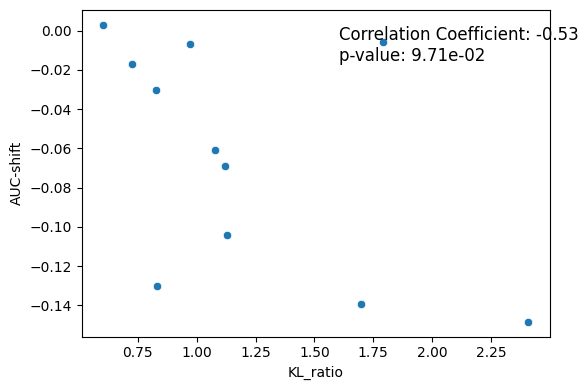

In [171]:
## Compare to raw accuracy drop 
metric = 'AUC'
LR_AUC = np.load('YAIB/results/dist_shift/LogisticRegression-AUC-n1500-diff-avg.npz')[metric]
data_addition['AUC-shift'] = np.delete(LR_AUC[:, hos_ind], hos_ind)
plot_scatter_with_correlation(data_addition, 'KL_ratio', 'AUC-shift')

In [172]:
data_addition.sort_values(by="KL_ratio")

,n,AUC,CI-lower,CI-upper,train_hospital,AUC-diff,KL_ratio,AUC-shift
20,3185.0,0.849377,0.833722,0.865033,300,0.007355,0.602058,0.003005
18,3228.0,0.849295,0.834777,0.863813,458,0.007273,0.725035,-0.016843
14,3381.0,0.841069,0.824828,0.857310,338,-0.000953,0.825389,-0.030090
26,3053.0,0.820927,0.803399,0.838456,167,-0.021095,0.830580,-0.130279
10,3712.0,0.836655,0.822036,0.851274,420,-0.005367,0.970331,-0.006967
8,3872.0,0.839165,0.823075,0.855256,264,-0.002857,1.079237,-0.060602
22,3149.0,0.825946,0.809512,0.842381,188,-0.016076,1.119531,-0.068852
12,3406.0,0.840458,0.825366,0.855550,243,-0.001564,1.129942,-0.104062
24,3105.0,0.829814,0.814133,0.845495,252,-0.012208,1.696442,-0.139444
16,3290.0,0.844368,0.829045,0.859690,443,0.002345,1.791594,-0.005813


In [116]:
results_x = [] 
for i, h in enumerate(hospital_ids): 
    if h != hos: 
        x, y, xy = ckl.get_hospital(h, 'train')
        x2, y2, xy2 = ckl.get_hospital(hos, 'train')

        xhalf1, xhalf2 = partition_array(x2)
        x = np.concatenate((x, xhalf1), axis=0)
        
        scaler = StandardScaler()
        logistic = LogisticRegression(max_iter=10000, tol=0.1)
        pipe = Pipeline(steps=[("scaler", scaler), ("logistic", logistic)])

        # fit x 
        X_train = np.concatenate((x, xhalf2), axis=0)
        Y_train = np.concatenate((np.ones(len(x)), np.zeros(len(xhalf2))), axis=0)
        
        pipe.fit(X_train, Y_train)
        
        x_val, _, _ = ckl.get_hospital(h, 'test')
        
        r = pipe.predict_proba(x_val)[:, 1]
        s = r/(1-r) 
        new_kl = np.log2(s).mean()

        # fit x 
        X_train = np.concatenate((xhalf1, xhalf2), axis=0)
        Y_train = np.concatenate((np.ones(len(xhalf1)), np.zeros(len(xhalf2))), axis=0)
        
        pipe.fit(X_train, Y_train)
        
        r = pipe.predict_proba(x_val)[:, 1]
        s = r/(1-r) 
        prev_kl = np.log2(s).mean()
        results_x.append(new_kl - prev_kl)

data_addition['Excess_KL'] = results_x

/tmp/ipykernel_629547/765427607.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_addition['Excess_KL'] = results_x


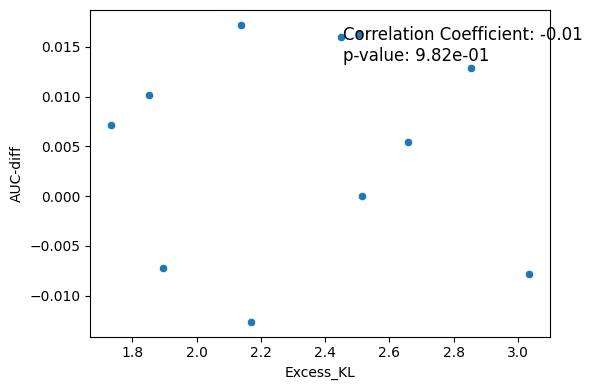

In [117]:
plot_scatter_with_correlation(data_addition, 'Excess_KL', 'AUC-diff')

In [360]:
results_x = np.zeros((len(hospital_ids), len(hospital_ids))) 
results_xy = np.zeros((len(hospital_ids), len(hospital_ids))) 
for test_i, test_h in enumerate(hospital_ids): 
    for i, h in enumerate(hospital_ids): 
        hos = test_h
        if h != hos: 
            x, y, xy = ckl.get_hospital(h, 'train')
            x2, y2, xy2 = ckl.get_hospital(hos, 'train')

            xhalf1, xhalf2 = partition_array(x2)
            x = np.concatenate((x, xhalf1), axis=0)
            
            scaler = StandardScaler()
            logistic = LogisticRegression(max_iter=10000, tol=0.1)
            pipe = Pipeline(steps=[("scaler", scaler), ("logistic", logistic)])

            
            # fit x 
            X_train = np.concatenate((x, xhalf2), axis=0)
            Y_train = np.concatenate((np.ones(len(x)), np.zeros(len(xhalf2))), axis=0)
            
            pipe.fit(X_train, Y_train)
            
            x_val, _, _ = ckl.get_hospital(h, 'test')
            results_x[i, test_i] = (pipe.predict_log_proba(x_val)[:, 1].mean())

            # fit xy 
            xyhalf1, xyhalf2 = partition_array(xy2)
            xy = np.concatenate((xy, xyhalf1), axis=0)
            
            X_train = np.concatenate((xy, xyhalf2), axis=0)
            Y_train = np.concatenate((np.ones(len(xy)), np.zeros(len(xyhalf2))), axis=0)
            
            pipe.fit(X_train, Y_train)
            _, _, xy_val = ckl.get_hospital(h, 'test')
            results_xy[i, test_i] = (pipe.predict_log_proba(xy_val)[:, 1].mean())

/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1407: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1407: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1407: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1407: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1407: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))


In [361]:
with open('YAIB/results/distances/KL-ratio-addition-xy.npy', 'wb') as f: 
    np.save(f, results_xy) 

with open('YAIB/results/distances/KL-ratio-addition-x.npy', 'wb') as f: 
    np.save(f, results_x) 

## Compute KL - True KL using density ratio

In [161]:
results_x = np.zeros((len(hospital_ids), len(hospital_ids))) 
results_xy = np.zeros((len(hospital_ids), len(hospital_ids))) 
for test_i, test_h in enumerate(hospital_ids): 
    for i, h in enumerate(hospital_ids): 
        hos = test_h
        if h != hos: 
            x, y, xy = ckl.get_hospital(h, 'train')
            x2, y2, xy2 = ckl.get_hospital(hos, 'train')
            scaler = StandardScaler()
            logistic = LogisticRegression(max_iter=10000, tol=0.1)
            pipe = Pipeline(steps=[("scaler", scaler), ("logistic", logistic)])
            
            X_train = np.concatenate((x, x2), axis=0)
            Y_train = np.concatenate((np.ones(len(x)), np.zeros(len(x2))), axis=0)
            
            pipe.fit(X_train, Y_train)
            
            x_val, _, _ = ckl.get_hospital(h, 'test')
            r = pipe.predict_proba(x_val)[:, 1]
            r = np.clip(r, 0.01, 0.99)
            s = r/(1-r) 
            results_x[i, test_i] = np.log2(s).mean()

            X_train = np.concatenate((xy, xy2), axis=0)
            Y_train = np.concatenate((np.ones(len(xy)), np.zeros(len(xy2))), axis=0)
            
            pipe.fit(X_train, Y_train)
            
            _, _, xy_val = ckl.get_hospital(h, 'test')
            r = pipe.predict_proba(xy_val)[:, 1]
            r = np.clip(r, 0.01, 0.99)
            s = r/(1-r) 
            results_xy[i, test_i] = np.log2(s).mean()

with open('YAIB/results/distances/KL-ratio-xy-true.npy', 'wb') as f: 
    np.save(f, results_xy) 

with open('YAIB/results/distances/KL-ratio-x-true.npy', 'wb') as f: 
    np.save(f, results_x) 

## Simple classifier probability heuristic

In [7]:
# ratio based KL
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

results_x = np.zeros((len(hospital_ids), len(hospital_ids))) 
results_xy = np.zeros((len(hospital_ids), len(hospital_ids))) 
for test_i, test_h in enumerate(hospital_ids): 
    for i, h in enumerate(hospital_ids): 
        hos = test_h
        if h != hos: 
            x, y, xy = ckl.get_hospital(h, 'train')
            x2, y2, xy2 = ckl.get_hospital(hos, 'train')
            scaler = StandardScaler()
            logistic = LogisticRegression(max_iter=10000, tol=0.1)
            pipe = Pipeline(steps=[("scaler", scaler), ("logistic", logistic)])
            
            X_train = np.concatenate((x, x2), axis=0)
            Y_train = np.concatenate((np.ones(len(x)), np.zeros(len(x2))), axis=0)
            
            pipe.fit(X_train, Y_train)
            
            x_val, _, _ = ckl.get_hospital(h, 'test')
            results_x[i, test_i] = pipe.predict_proba(x_val)[:, 1].mean()

            X_train = np.concatenate((xy, xy2), axis=0)
            Y_train = np.concatenate((np.ones(len(xy)), np.zeros(len(xy2))), axis=0)
            
            pipe.fit(X_train, Y_train)
            
            _, _, xy_val = ckl.get_hospital(h, 'test')
            results_xy[i, test_i] = pipe.predict_proba(xy_val)[:, 1].mean()

with open('YAIB/results/distances/score-xy.npy', 'wb') as f: 
    np.save(f, results_xy) 

with open('YAIB/results/distances/score-x.npy', 'wb') as f: 
    np.save(f, results_x) 